In [3]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

from fastai.conv_learner import *
from fastai.dataset import *

import pandas as pd
from pathlib import Path
import json
from PIL import ImageDraw, ImageFont
from matplotlib import patches, patheffects
from collections import namedtuple, OrderedDict
torch.cuda.set_device(0)

C:\Users\Drake\AppData\Local\conda\conda\envs\fastai\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [4]:
torch.cuda.is_available(), torch.cuda.get_device_name(0), torch.backends.cudnn.enabled

(True, 'GeForce GTX 960M', True)

In [5]:
def show_img(im, figsize=None, ax=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    return ax

In [6]:
def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])

In [7]:
def draw_rect(ax, b):
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor='white', lw=2))
    draw_outline(patch, 4)

In [8]:
def draw_text(ax, xy, txt, sz=14):
    text = ax.text(*xy, txt,
        verticalalignment='top', color='white', fontsize=sz, weight='bold')
    draw_outline(text, 1)

In [9]:
def bbtohw(a): 
    """Bounding box to Height width.

    Args:
        param1 (arr): [xmin, ymin, xmax, ymax] where (xmin, ymin) 
            and (xmax, ymax) represent the top left and bottom 
            right corners of the bounding box

    Returns:
        arr: [xmin, ymin, width, height]

    """
    return [a[0],a[1],a[2]-a[0],a[3]-a[1]]

assert bbtohw([2, 5, 10, 20]) == [2, 5, 8, 15]

In [10]:
DATA_DIR = "data/road_damage_dataset"

In [11]:
DATA_PATH = Path(DATA_DIR)

In [12]:
def split(df, group):
    data = namedtuple('data', ['filename', 'object'])
    gb = df.groupby(group)
    return [data(filename, gb.get_group(x)) for filename, x in zip(gb.groups.keys(), gb.groups)]

In [13]:
examples = pd.read_csv(DATA_PATH/'train_labels.csv')
images = split(examples, 'filename')

In [14]:
print(images[0])

data(filename='Adachi/JPEGImages/train_Adachi_00001.jpg', object=                                      filename  width  height class  xmin  \
9382  Adachi/JPEGImages/train_Adachi_00001.jpg    600     600   D44   424   
9383  Adachi/JPEGImages/train_Adachi_00001.jpg    600     600   D10   114   

      ymin  xmax  ymax  
9382   361   590   546  
9383   432   487   543  )


In [15]:
def print_example(example):
    im = open_image(DATA_PATH/example.filename)
    ax = show_img(im)
    for index, row in example.object.iterrows():
        bb = bbtohw([row['xmin'], row['ymin'], row['xmax'], row['ymax']]) # Bounding box converted to height width
        draw_rect(ax, bb)
        draw_text(ax, bb[:2], row['class'])  

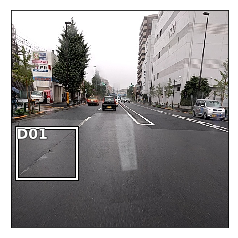

In [16]:
print_example(images[6])

# Multi Class

In [17]:
MULTICLASS_CSV_PATH = DATA_PATH/'mc.csv'

In [18]:
mc = [set([row['class'] for index, row in img.object.iterrows()]) for img in images]
mcs = [' '.join(label for label in labels) for labels in mc]
print(mc[0:4])
print(mcs[0:4])

[{'D10', 'D44'}, {'D01'}, {'D01'}, {'D00', 'D01'}]
['D10 D44', 'D01', 'D01', 'D00 D01']


In [69]:
df = pd.DataFrame({'filename': [img.filename for img in images], 'class': mcs}, columns=['filename','class'])
df.to_csv(MULTICLASS_CSV_PATH, index=False)

## Train Round 1: Setup, Last Layer Only

In [77]:
f_model=resnet34
sz=224
bs=16

In [78]:
tfms = tfms_from_model(f_model, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
md = ImageClassifierData.from_csv(DATA_PATH, '', MULTICLASS_CSV_PATH, tfms=tfms, bs=bs)

In [79]:
learn = ConvLearner.pretrained(f_model, md, precompute=True)
learn.opt_fn = optim.Adam

In [80]:
lrf=learn.lr_find(1e-5,100)

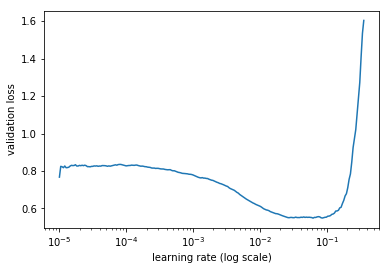

In [81]:
learn.sched.plot(0)

In [82]:
lr = 2e-2

In [83]:
learn.fit(lr, 1, cycle_len=3, use_clr=(32,5)) 
# Since precompute=true, these first 3 epochs will not use dataaugmentation

epoch      trn_loss   val_loss   <lambda>                                      
    0      0.399018   0.382983   0.825963  
    1      0.370656   0.382536   0.830777                                      
    2      0.356993   0.360742   0.837019                                      


[array([0.36074]), 0.8370185450208341]

## Train Round 2: All layers + Data Augmentation

In [84]:
learn.precompute=False
# Take advantage of data augmentation

In [85]:
lrs = np.array([lr/9, lr/3, lr])

In [86]:
learn.unfreeze()

 71%|████████████████████▍        | 248/351 [02:49<01:10,  1.46it/s, loss=1.38]

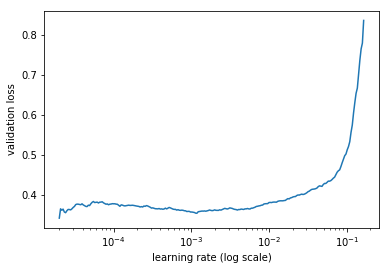

In [87]:
learn.lr_find(lrs/1000)
learn.sched.plot(0)

In [123]:
learn.fit(lrs/10, 1, cycle_len=10, use_clr=(32,5))

epoch      trn_loss   val_loss   <lambda>                                      
    0      0.289493   0.31203    0.882133  
    1      0.25653    0.277283   0.891583                                      
    2      0.233618   0.250298   0.90041                                       


[array([0.2503]), 0.900410128302989]

In [124]:
learn.save('mclas')
learn.load('mclas')

## Train round 3: Last Layer Only + Increase Input Size

In [ ]:
sz=299
bs=16

tfms = tfms_from_model(f_model, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
md = ImageClassifierData.from_csv(DATA_PATH, '', MULTICLASS_CSV_PATH, tfms=tfms, bs=bs)

learn.set_data(md)

In [127]:
learn.freeze()

 63%|█████████████████▌          | 220/351 [01:51<01:06,  1.98it/s, loss=0.782]

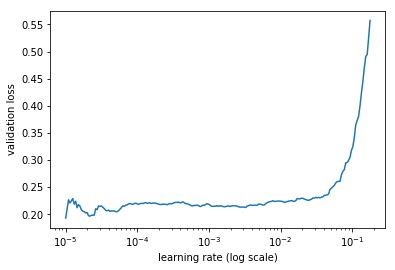

In [131]:
learn.lr_find(1e-5,100)
learn.sched.plot(0)

In [132]:
lr = 4e-3

In [134]:
learn.fit(lr, 1, cycle_len=5, use_clr=(32,5))

epoch      trn_loss   val_loss   <lambda>                                      
    0      0.25996    0.28669    0.899519  
    1      0.250262   0.253901   0.904244                                      
    2      0.23485    0.255726   0.904779                                      
    3      0.226773   0.309396   0.90148                                       
    4      0.214074   0.228362   0.908256                                      


[array([0.22836]), 0.9082560629375311]

In [139]:
learn.save('mclas_299')
learn.load('mclas_299')

## Train Round 4: All layers + Larger Input Size

In [146]:
lrs = np.array([lr/9, lr/3, lr])

In [147]:
learn.unfreeze()

In [148]:
learn.lr_find(lrs/1000)
learn.sched.plot(0)

  0%|                                                  | 0/351 [00:00<?, ?it/s]

RuntimeError: cuda runtime error (2) : out of memory at d:\pytorch\pytorch\torch\lib\thc\generic/THCStorage.cu:58

In [143]:
learn.fit(lrs/10, 1, cycle_len=5, use_clr=(32,5))

  0%|                                                  | 0/351 [00:00<?, ?it/s]

RuntimeError: cuda runtime error (2) : out of memory at d:\pytorch\pytorch\torch\lib\thc\generic/THCStorage.cu:58

## Let's show some predicitions

In [145]:
y = predict(learn.model, learn.data.val_dl)
x,_ = next(iter(md.val_dl))
x = to_np(x)

RuntimeError: cuda runtime error (2) : out of memory at d:\pytorch\pytorch\torch\lib\thc\generic/THCStorage.cu:58

In [ ]:
fig, axes = plt.subplots(3, 4, figsize=(12, 8))
for i,ax in enumerate(axes.flat):
    image_data=md.val_ds.denorm(x)[i]
    ax = show_img(image_data, ax=ax)
    
    predicted_labels = np.nonzero(y[i]>0.4)[0]
    label_string = '\n'.join(md.classes[label] for label in predicted_labels)  
    draw_text(ax, (0,0), label_string)
    
    ground_labels = np.nonzero(_[i]>0)[0]
    ground_label_string = '\n'.join(md.classes[label] for label in ground_labels)  
    draw_text(ax, (50,0), ground_label_string)
    
plt.tight_layout()